For the Dubin’s model of a car the defining equations can be written as:
$$ \dot x  = v\ cos(θ) \\
\dot y  = v sin(θ) \\  
 \dot \theta = \frac{v}{L}tan(\theta) $$
Where v is the linear velocity of the car, x and y are positions of the car on the 2d plane and θ is its angle with the x axis, and $\phi$ is the steering angle. L is the distance between the wheel axles, which we assume to be 0.5 meters.

We also know that we cannot control any of these variables directly, so we use the control inputs acceleration a and rate of steering ψ.

With these, we can arrive at the state space model

$$X = AX + U$$

Where $$X  = [x, y, \theta , v, \phi]^T$$ is the state vector, $$U = [a, \psi]$$  is the input or control vector and	$$\dot X  = [v\ cos(\theta), v\ sin(\theta) , \frac{V}{L} tan(\phi), a, \psi]^T$$ is the system equation.


Randomly sampling control values from a range of (-10,10) for acceleration and $\psi$ within (-3,3).

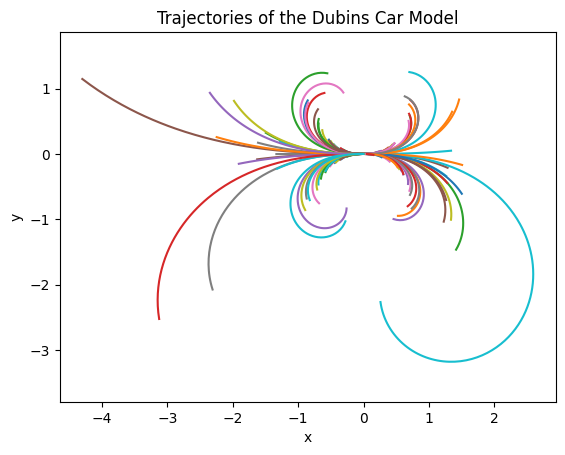

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from math import sin, cos, tan, pi

L = 0.5  # Length between the wheels
dt = 0.01  # Time step
simulation_time = 10  # Total simulation time
num_trajectories = 100  # Number of trajectories to simulate

def random_control(t):
    """Generate random acceleration and steering angle."""
    a = np.random.uniform(-10,10)
    psi = np.random.uniform(-3,3)
    return np.array([a, psi])

def check_constraints(state):
    """Check if the state violates any constraints."""
    v, phi = state[3], state[4]
    return not (-5 <= v <= 5 and (-np.pi / 3) <= phi <= (np.pi / 3))

def dubin(state, control, dt):
    """Update the state based on control inputs."""
    x, y, theta, v, phi = state
    a, psi = control
    v += a * dt
    phi += psi * dt
    theta_dot = v / L * tan(phi)
    x_dot = v * cos(theta)
    y_dot = v * sin(theta)
    x += x_dot * dt
    y += y_dot * dt
    theta += theta_dot * dt
    return np.array([x, y, theta, v, phi])

trajectories = []  # Store trajectories here

for _ in range(num_trajectories):
  t = 0
  state = np.array([0, 0, 0, 0, 0])  # Initial state [x, y, theta, v, phi]
  trajectory = []
  control = random_control(t)
  for _ in np.arange(0, simulation_time, dt):
      state = dubin(state, control, dt)
      if check_constraints(state):
          break  # Stop this trajectory if constraints are violated
      trajectory.append(state[:2])  # Store only x and y for plotting
  trajectories.append(trajectory)
  t += t*dt

# Plotting
for trajectory in trajectories:
    trajectory = np.array(trajectory)
    plt.plot(trajectory[:, 0], trajectory[:, 1], '-')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Trajectories of the Dubins Car Model')
plt.axis('equal')
plt.show()

Now, we make $a(t) = 10\ sin(10t+c)$ and $\psi(t) = 3\ sin(4t+d)$, where $c$ and $d$ are sampled in the range $[0, 2\pi]$

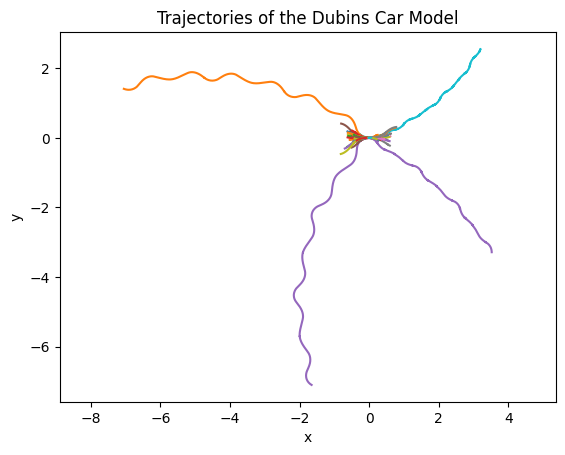

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from math import sin, cos, tan, pi

L = 0.5  # Length between the wheels
dt = 0.01  # Time step
simulation_time = 10  # Total simulation time
num_trajectories = 100  # Number of trajectories to simulate

def random_control(t):
    """Generate random acceleration and steering angle."""
    c = np.random.uniform(0, 2*np.pi)
    d = np.random.uniform(0, 2*np.pi)
    return np.array([c, d])

def check_constraints(state):
    """Check if the state violates any constraints."""
    x,y,_,v, phi = state
    return not (-5 <= v <= 5 and (-np.pi / 3) <= phi <= (np.pi / 3) and (-10) <= x <= (10) and (-10) <= y <= (10))

def dubin(state, control, dt):
    """Update the state based on control inputs."""
    x, y, theta, v, phi = state
    a, psi = control
    v += a * dt
    phi += psi * dt
    theta_dot = v / L * tan(phi)
    x_dot = v * cos(theta)
    y_dot = v * sin(theta)
    x += x_dot * dt
    y += y_dot * dt
    theta += theta_dot * dt
    return np.array([x, y, theta, v, phi])

trajectories = []  # Store trajectories here

for _ in range(num_trajectories):
  t = 0
  state = np.array([0, 0, 0, 0, 0])  # Initial state [x, y, theta, v, phi]
  trajectory = []
  #pick a c and d value
  c,d = random_control(t)
  for _ in np.arange(0, simulation_time, dt):
    a = 10*sin(10*t + c)
    psi = 4*sin(4*t + d)
    control = np.array([a,psi])
    state = dubin(state, control, dt)
    t += dt
    if check_constraints(state):
          break  # Stop this trajectory if constraints are violated
    trajectory.append(state[:2])  # Store only x and y for plotting
  trajectories.append(trajectory)


# Plotting
for trajectory in trajectories:
    trajectory = np.array(trajectory)
    plt.plot(trajectory[:, 0], trajectory[:, 1], '-')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Trajectories of the Dubins Car Model')
plt.axis('equal')
plt.show()

We will now build a kinodynamic RRT for the above Dubin's car model.

We will start from the initial state 0, sample a configuration $(p_x,p_y)$ in the range $[-10,10]$ and the rest of the constraints from above.

After selecting the nearest state, based on a distance metric, we will sample a random time step $\Delta t$ between [0s,1s] and simulate the system forward to reach the new node, and also reject all nodes that do not fulfil the above constraints.

Our distance metric would be the weighted Euclidean distance, except for the $\theta$ dimension which would be the geodesic distance in SO(2).

We simulate the RRT for 1000 iterations and plot the tree.

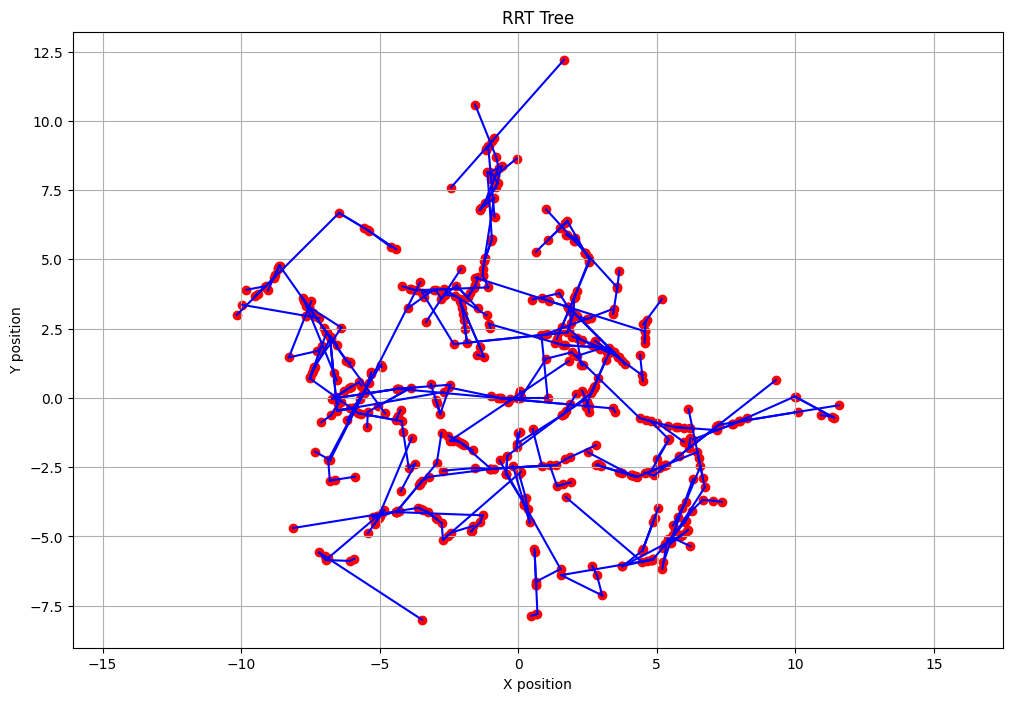

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from math import sin, cos, tan, pi

# Constants given in the problem
L = 0.5  # Length between the wheels

# Weights for the distance metric
w_x = 1
w_y = 1
w_theta = 1  # The weight for the geodesic distance in SO(2)
w_v = 1
w_phi = 1

# State space bounds
x_bounds = (-10, 10)
y_bounds = (-10, 10)
theta_bounds = (-pi, pi)
v_bounds = (-5, 5)
phi_bounds = (-pi/3, pi/3)

# Distance metric including the geodesic distance in SO(2)
def distance_metric(state1, state2):
    x1, y1, theta1, v1, phi1 = state1
    x2, y2, theta2, v2, phi2 = state2

    # Geodesic distance for theta
    d_theta = geodesic(theta1, theta2)

    # Weighted Euclidean distance
    dist = np.sqrt(
        w_x * (x1 - x2)**2 +
        w_y * (y1 - y2)**2 +
        w_theta * d_theta**2 +
        w_v * (v1 - v2)**2 +
        w_phi * (phi1 - phi2)**2
    )
    return dist

def geodesic(theta1, theta2):
    # Calculate the raw difference
    raw_diff = theta2 - theta1
    # Normalize the difference within the range -π to π
    if raw_diff > np.pi:
        return raw_diff - 2 * np.pi
    elif raw_diff <= -np.pi:
        return raw_diff + 2 * np.pi
    else:
        return raw_diff

# Random state generator
def random_state():
    x = np.random.uniform(*x_bounds)
    y = np.random.uniform(*y_bounds)
    theta = np.random.uniform(*theta_bounds)
    v = np.random.uniform(*v_bounds)
    phi = np.random.uniform(*phi_bounds)
    return np.array([x, y, theta, v, phi])

# The control input generator function
def random_control():
    a = np.random.uniform(-10, 10)
    psi = np.random.uniform(-3, 3)
    dt = np.random.uniform(0, 1)
    return np.array([a, psi, dt])

simulation_time = 10  # Total simulation time
num_trajectories = 1000  # Number of trajectories to simulate

def check_constraints(state):
    """Check if the state violates any constraints."""
    v, phi = state[3], state[4]
    return not (-5 <= v <= 5 and (-np.pi / 3) <= phi <= (np.pi / 3))

def dubin(state, control, dt):
    """Update the state based on control inputs."""
    x, y, theta, v, phi = state
    a, psi = control
    v += a * dt
    phi += psi * dt
    theta_dot = v / L * tan(phi)
    x_dot = v * cos(theta)
    y_dot = v * sin(theta)
    x += x_dot * dt
    y += y_dot * dt
    theta += theta_dot * dt
    return np.array([x, y, theta, v, phi])

# The main loop to build the RRT with connections
def build_rrt_with_connections():
    nodes = [np.zeros(5)]  # Start with the initial state at the origin
    parents = [-1]  # -1 for the root node which has no parent
    for i in range(1000):
        rand_state = random_state()
        nearest_index = min(range(len(nodes)), key=lambda j: distance_metric(nodes[j], rand_state))
        control = random_control()
        new_state = dubin(nodes[nearest_index], control[:2], control[2])

        if not check_constraints(new_state):
            nodes.append(new_state)
            parents.append(nearest_index)  # Store the index of the nearest node as the parent

    return nodes, parents

# Running the RRT algorithm
rrt_tree, connections = build_rrt_with_connections()

# Plotting the RRT tree (x, y) positions with connections
plt.figure(figsize=(12, 8))
for i in range(1, len(rrt_tree)):
    # Draw a line from each node to its parent
    start_state = rrt_tree[connections[i]]
    end_state = rrt_tree[i]
    plt.plot([start_state[0], end_state[0]], [start_state[1], end_state[1]], 'b-')

# Plot the nodes on top of the connections
x_positions = [state[0] for state in rrt_tree]
y_positions = [state[1] for state in rrt_tree]
plt.scatter(x_positions, y_positions, c='r')

plt.xlabel('X position')
plt.ylabel('Y position')
plt.title('RRT Tree')
plt.axis('equal')  # Equal scaling of the axes.
plt.grid(True)
plt.show()


Now we play around with the weights a bit, to generate an RRT with a more wide exploration than narrow, and then the opposite.

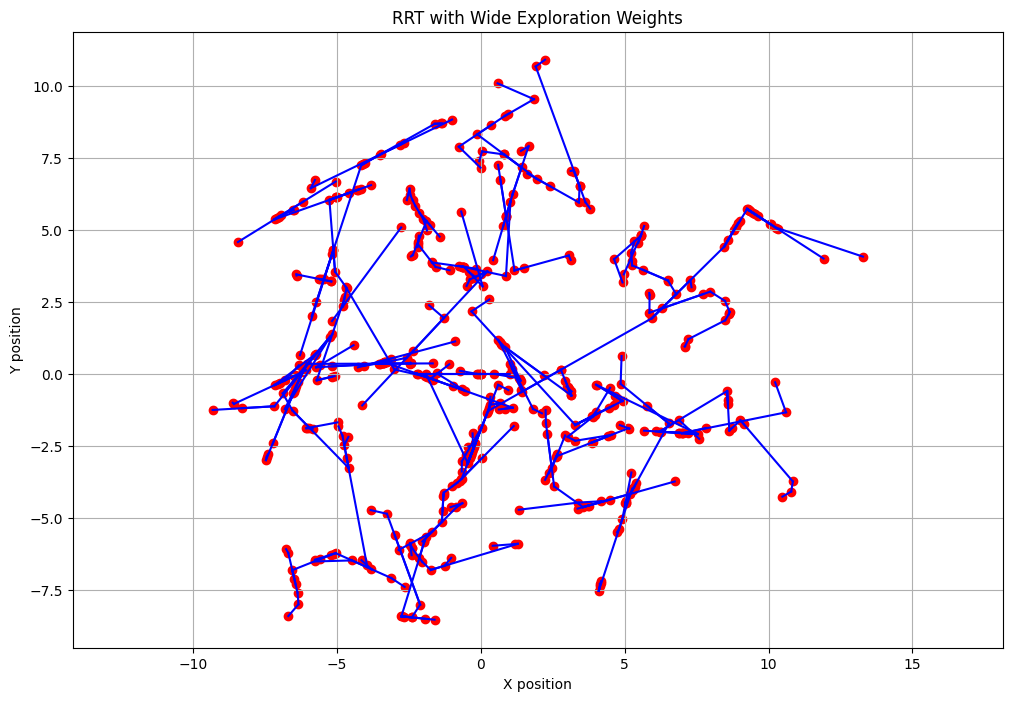

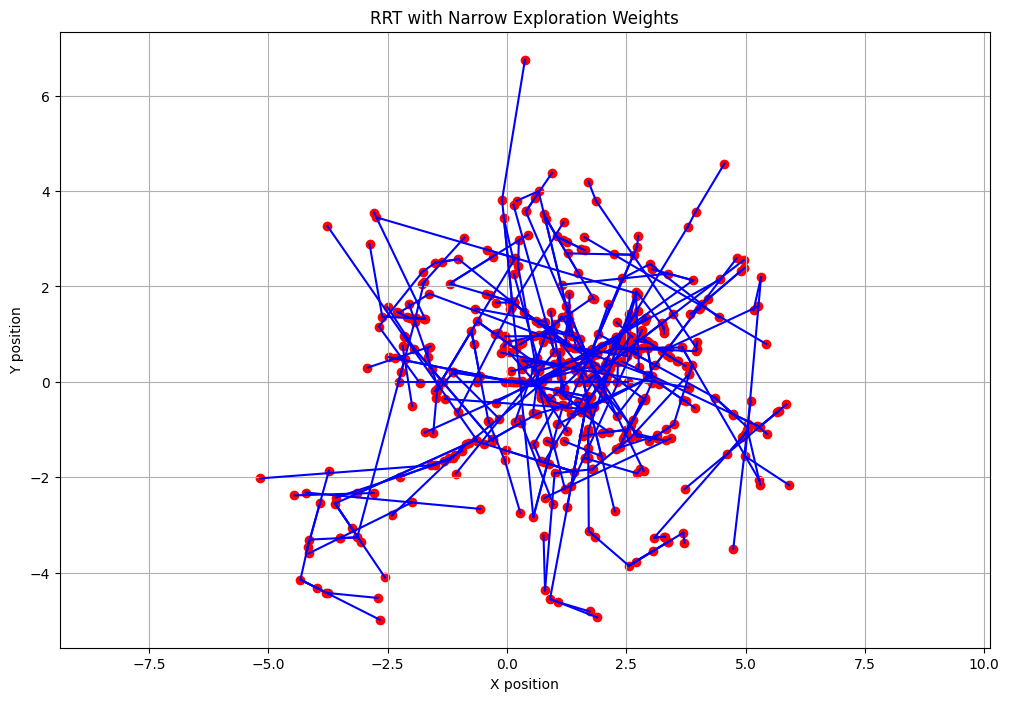

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from math import sin, cos, tan, pi

# Function to build RRT with two different sets of weights
def build_rrt(weight_set):
    nodes = [np.zeros(5)]  # Start with the initial state at the origin
    parents = [-1]  # -1 for the root node which has no parent

    # Unpack the weights for the distance metric
    w_x, w_y, w_theta, w_v, w_phi = weight_set

    # Distance metric function with the current set of weights
    def distance_metric(state1, state2):
        x1, y1, theta1, v1, phi1 = state1
        x2, y2, theta2, v2, phi2 = state2

        # Geodesic distance for theta
        d_theta = geodesic(theta1, theta2)

        # Weighted Euclidean distance
        dist = np.sqrt(
            w_x * (x1 - x2)**2 +
            w_y * (y1 - y2)**2 +
            w_theta * d_theta**2 +
            w_v * (v1 - v2)**2 +
            w_phi * (phi1 - phi2)**2
        )
        return dist

    # Build the RRT
    for i in range(1000):
        rand_state = random_state()
        nearest_index = min(range(len(nodes)), key=lambda j: distance_metric(nodes[j], rand_state))
        control = random_control()
        new_state = dubin(nodes[nearest_index], control[:2], control[2])

        if not check_constraints(new_state):
            nodes.append(new_state)
            parents.append(nearest_index)  # Store the index of the nearest node as the parent

    return nodes, parents

# Weights for distance metric that promotes wide exploration
wide_explore_weights = (10, 10, 0.1, 0.1, 0.1)

# Weights for distance metric that does not promote wide exploration
narrow_explore_weights = (0.1, 0.1, 10, 10, 10)

# Build RRT with wide exploration weights
rrt_wide_tree, rrt_wide_connections = build_rrt(wide_explore_weights)

# Build RRT with narrow exploration weights
rrt_narrow_tree, rrt_narrow_connections = build_rrt(narrow_explore_weights)

# Plotting function
def plot_rrt(rrt_tree, connections, title):
    plt.figure(figsize=(12, 8))
    for i in range(1, len(rrt_tree)):
        start_state = rrt_tree[connections[i]]
        end_state = rrt_tree[i]
        plt.plot([start_state[0], end_state[0]], [start_state[1], end_state[1]], 'b-')

    x_positions = [state[0] for state in rrt_tree]
    y_positions = [state[1] for state in rrt_tree]
    plt.scatter(x_positions, y_positions, c='r')
    plt.xlabel('X position')
    plt.ylabel('Y position')
    plt.title(title)
    plt.axis('equal')
    plt.grid(True)

# Plot RRT with wide exploration weights
plot_rrt(rrt_wide_tree, rrt_wide_connections, 'RRT with Wide Exploration Weights')

# Plot RRT with narrow exploration weights
plot_rrt(rrt_narrow_tree, rrt_narrow_connections, 'RRT with Narrow Exploration Weights')

plt.show()

Now we try to goal bias the RRT towards a fixed target at (5,0), with zero velocity. We try 10% goal tending, 50% and finally 90% and plot the resulting RRTs.

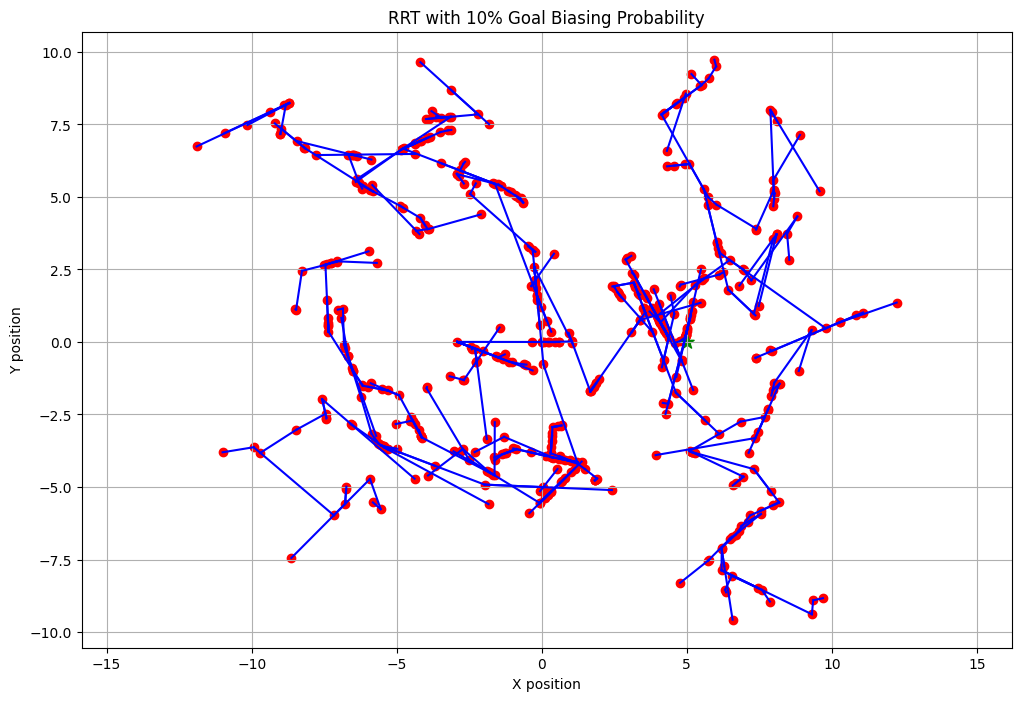

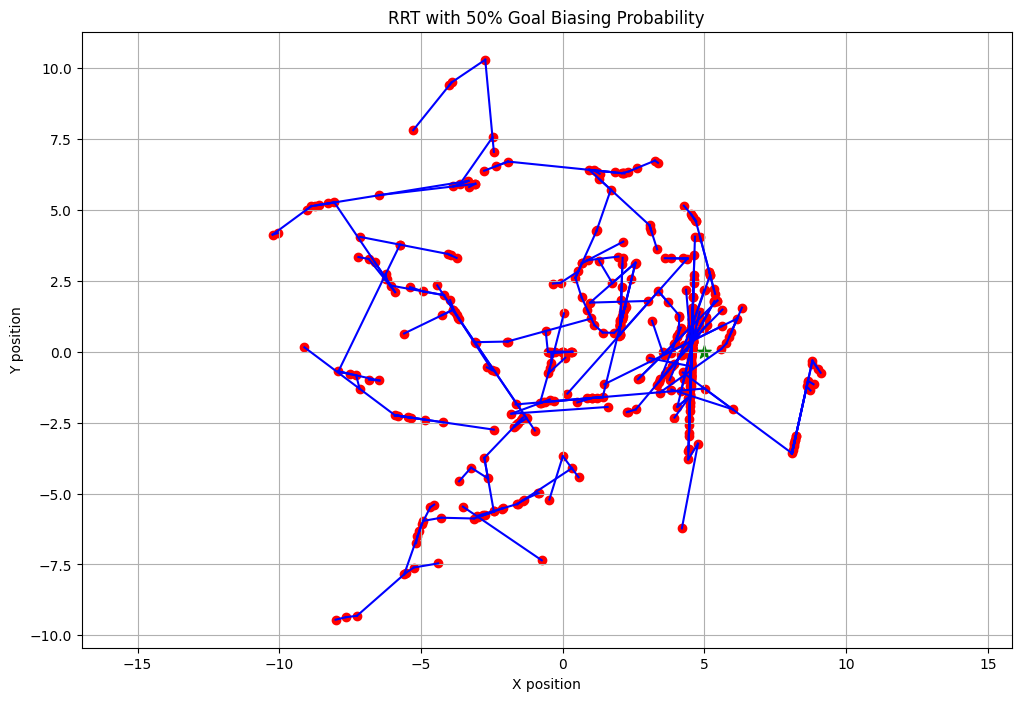

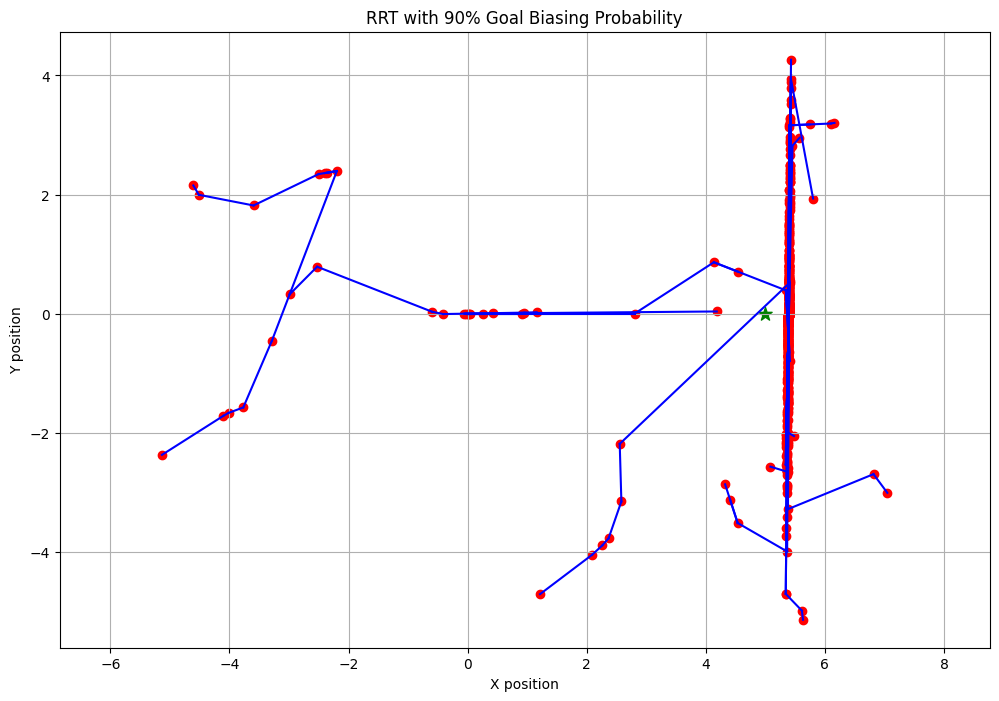

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from math import sin, cos, tan, pi

# Constants given in the problem
L = 0.5  # Length between the wheels

# State space bounds
x_bounds = (-10, 10)
y_bounds = (-10, 10)
theta_bounds = (-pi, pi)
v_bounds = (-5, 5)
phi_bounds = (-pi/3, pi/3)

# Distance metric including the geodesic distance in SO(2)
def distance_metric(state1, state2):
    x1, y1, theta1, v1, phi1 = state1
    x2, y2, theta2, v2, phi2 = state2

    # Geodesic distance for theta
    d_theta = geodesic(theta1, theta2)

    # Weighted Euclidean distance
    dist = np.sqrt(
        w_x * (x1 - x2)**2 +
        w_y * (y1 - y2)**2 +
        w_theta * d_theta**2 +
        w_v * (v1 - v2)**2 +
        w_phi * (phi1 - phi2)**2
    )
    return dist

def geodesic(theta1, theta2):
    # Calculate the raw difference
    raw_diff = theta2 - theta1
    # Normalize the difference within the range -π to π
    if raw_diff > np.pi:
        return raw_diff - 2 * np.pi
    elif raw_diff <= -np.pi:
        return raw_diff + 2 * np.pi
    else:
        return raw_diff
# Constants, bounds, and functions defined earlier will be used here...
# Let's redefine the random_state function to include goal biasing.

def random_state_with_goal(goal, goal_bias_probability):
    if np.random.rand() < goal_bias_probability:
        return goal
    else:
        return random_state()

def random_state():
    x = np.random.uniform(*x_bounds)
    y = np.random.uniform(*y_bounds)
    theta = np.random.uniform(*theta_bounds)
    v = np.random.uniform(*v_bounds)
    phi = np.random.uniform(*phi_bounds)
    return np.array([x, y, theta, v, phi])

# Define the goal state 5 meters away, with zero velocity and desired orientation
goal_state = np.array([5, 0, 0, 0, 0])  # Assume goal is directly to the right for simplicity

wide_explore_weights = (10, 10, 0.1, 0.1, 0.1)

def check_constraints(state):
    """Check if the state violates any constraints."""
    v, phi = state[3], state[4]
    return not (-5 <= v <= 5 and (-np.pi / 3) <= phi <= (np.pi / 3))

# Function to build RRT with goal biasing
def build_rrt_with_goal_biasing(goal, goal_bias_probability):
    nodes = [np.zeros(5)]  # Start with the initial state at the origin
    parents = [-1]  # -1 for the root node which has no parent

    # We'll use the wide exploration weights for this as a starting point
    w_x, w_y, w_theta, w_v, w_phi = wide_explore_weights

    # Distance metric function with the current set of weights
    def distance_metric(state1, state2):
        x1, y1, theta1, v1, phi1 = state1
        x2, y2, theta2, v2, phi2 = state2

        # Geodesic distance for theta
        d_theta = geodesic(theta1, theta2)

        # Weighted Euclidean distance
        dist = np.sqrt(
            w_x * (x1 - x2)**2 +
            w_y * (y1 - y2)**2 +
            w_theta * d_theta**2 +
            w_v * (v1 - v2)**2 +
            w_phi * (phi1 - phi2)**2
        )
        return dist

    # Build the RRT
    for i in range(1000):
        rand_state = random_state_with_goal(goal, goal_bias_probability)
        nearest_index = min(range(len(nodes)), key=lambda j: distance_metric(nodes[j], rand_state))
        control = random_control()
        new_state = dubin(nodes[nearest_index], control[:2], control[2])

        if not check_constraints(new_state):
            nodes.append(new_state)
            parents.append(nearest_index)  # Store the index of the nearest node as the parent

    return nodes, parents

# Plotting function
def plot_rrt(rrt_tree, connections, title, goal):
    plt.figure(figsize=(12, 8))
    for i in range(1, len(rrt_tree)):
        start_state = rrt_tree[connections[i]]
        end_state = rrt_tree[i]
        plt.plot([start_state[0], end_state[0]], [start_state[1], end_state[1]], 'b-')

    x_positions = [state[0] for state in rrt_tree]
    y_positions = [state[1] for state in rrt_tree]
    plt.scatter(x_positions, y_positions, c='r')
    plt.scatter(goal[0], goal[1], c='g', marker='*', s=100)  # Plot the goal
    plt.xlabel('X position')
    plt.ylabel('Y position')
    plt.title(title)
    plt.axis('equal')
    plt.grid(True)

# Define goal biasing probabilities
goal_bias_probabilities = [0.1, 0.5, 0.9]
# goal_bias_probabilities = [0.9]

# Generate and plot RRTs for each goal biasing probability
for p in goal_bias_probabilities:
    rrt_tree, connections = build_rrt_with_goal_biasing(goal_state, p)
    plot_rrt(rrt_tree, connections, f'RRT with {int(p*100)}% Goal Biasing Probability', goal_state)

plt.show()


Trajectory optimization (in progress)

In [18]:
import numpy as np
from scipy.optimize import minimize

# Initial and target states for demonstration
initial_state = np.array([0, 0, 0, 0, 0])  # x, y, theta, v, phi
target_state = np.array([5, 0, 0, 0, 0])  # Target position and orientation

# Objective function to be minimized
def objective_function(controls_flattened):
    num_steps = len(controls_flattened) // 3  # Assuming each control is represented by a, psi, dt
    controls = controls_flattened.reshape((num_steps, 3))

    state = np.copy(initial_state)
    for control in controls:
        a, psi, dt = control
        state = dubin(state, [a, psi], dt)

    # Calculate the cost based on the final state and control effort
    final_position_error = np.linalg.norm(state[:2] - target_state[:2])
    final_orientation_error = abs(geodesic(state[2], target_state[2]))
    control_effort = np.sum(np.abs(controls))  # Simple control effort cost

    return final_position_error + final_orientation_error * 10 + control_effort * 0.01

# Optimization procedure
def optimize_trajectory(initial_guess):
    result = minimize((objective_function), initial_guess, method='SLSQP', options={'disp': True})
    return result.x.reshape((-1, 3)), result.fun

# Initial guess for the controls (a series of accelerations, steering rates, and time durations)
num_controls = 100  # Let's start with 10 control steps
initial_guess = [0,0,0]  # Random initial guess

# Perform the optimization
optimized_controls, final_cost = optimize_trajectory(initial_guess)

print("Optimized Controls:\n", optimized_controls)
print("Final Cost:", final_cost)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 5.000000000285592
            Iterations: 1
            Function evaluations: 15
            Gradient evaluations: 1
Optimized Controls:
 [[-9.51973319e-09 -9.51973319e-09 -9.51973319e-09]]
Final Cost: 5.000000000285592
